In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from simulation import simulation
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
# Intensity parameter
epsilon = 1. # .25 or 1.

r1 = -54.1669
if epsilon == .25:
    r0 = -4.3830
elif epsilon == 1.:
    r0 = -1.0957

# Robustness parameters
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 2.0
y_bar_lower = 1.7

# Grid setting
ϵ = 1.
y_step = .02
y_grid_long = np.linspace(0., 4., int(4/y_step) + 1)
y_grid_short = np.linspace(0., y_bar_upper-y_step, int(2/y_step))
y_grid_tilde = np.linspace(y_bar_lower, y_bar_upper-y_step, int((y_bar_upper-y_bar_lower)/y_step))

In [3]:
# Parallelly solve ODE
model_args_low = []
model_args_high = []
model_args_extreme = []

model_paras_low = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[0], y_bar_upper)

for y_jump in y_grid_tilde:
    model_paras_high = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[1], y_jump)
    model_paras_extreme = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[2], y_jump)
    model_args_high.append((y_grid_long, model_paras_high, None, ϵ, 1e-8, 5000, False))
    model_args_extreme.append((y_grid_long, model_paras_extreme, None, ϵ, 1e-8, 5000, False))

print('----- Solving low damage model -----')
model_low = ode_y(y_grid_long, model_paras_low, None, ϵ, 1e-8, 5000, False)
print('----- Solving high damage models -----')
model_high_list = ode_y_parallel(model_args_high)
print('----- Solving extreme damage models -----')
model_extreme_list = ode_y_parallel(model_args_extreme)

----- Solving low damage model -----
Converged. Total iteration 5000: LHS Error: 2.696741196572816e-05; RHS Error 8.034055397260209e-05
----- Solving high damage models -----
----- Solving extreme damage models -----


In [4]:
# Prepare ϕ_m
ϕ_m = np.zeros((3, len(y_grid_short)))
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
for i in range(len(y_grid_tilde)):
    ϕ_m[0, y_bar_lower_loc+i] = model_low['v0'][y_bar_lower_loc+i]
    ϕ_m[1, y_bar_lower_loc+i] = model_high_list[i]['v0'][y_bar_lower_loc+i]
    ϕ_m[2, y_bar_lower_loc+i] = model_extreme_list[i]['v0'][y_bar_lower_loc+i]

In [5]:
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper-y_step)
temp_1 = model_low['v0'][:y_bar_upper_loc+1]
temp_2 = model_high_list[-1]['v0'][:y_bar_upper_loc+1]
temp_3 = model_extreme_list[-1]['v0'][:y_bar_upper_loc+1]
v_guess = np.average(np.array([temp_1, temp_2, temp_3]), weights=πd_o, axis=0)

In [32]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, epsilon = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = -η*(y_grid+y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    intensity = r0 * (np.exp(r1 / 2. * (y_grid-y_bar_lower)**2) - 1.) * (y_grid >= y_bar_lower)\
                + 0 * (y_grid < y_bar_lower)

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)
#             e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp) * (temp < 0)\
#                       + (-G*np.sum(πc*θ, axis=0) + np.sqrt(root)) / (2*temp) * (temp > 0)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5

        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        g = np.exp(1. / ξ_2m * (v0 - ϕ_i))

        A = np.ones_like(y_grid)*(-δ) - intensity * np.sum(πd_o * g, axis=0)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            + ξ_2m * intensity * np.sum(πd_o * (1 - g + g * np.log(g)), axis=0)\
            + intensity * np.sum(πd_o * g * ϕ_i, axis=0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    check = np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0)

#     e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp) * (temp < 0)\
#               + (-G*np.sum(πc*θ, axis=0) + np.sqrt(root)) / (2*temp) * (temp > 0)    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'check': check,
           'πc': πc,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [33]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, epsilon)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=.5,
                                          tol=1e-8, max_iter=10_000, print_all=True)

Iteration 1: LHS Error: 0.6299647316631796; RHS Error 0.629962205935154
Iteration 2: LHS Error: 0.44862273968957567; RHS Error 0.45128786296623985
Iteration 3: LHS Error: 0.3366533060482506; RHS Error 0.34166212096925824
Iteration 4: LHS Error: 0.26651172431794024; RHS Error 0.2725614684665788
Iteration 5: LHS Error: 0.22071901011881856; RHS Error 0.2279061942156334
Iteration 6: LHS Error: 0.18974642880865167; RHS Error 0.19624300520897006
Iteration 7: LHS Error: 0.16507068106218803; RHS Error 0.1719953674183774
Iteration 8: LHS Error: 0.14911994576497456; RHS Error 0.15610413445749816
Iteration 9: LHS Error: 0.1345538776312225; RHS Error 0.1427449173964428
Iteration 10: LHS Error: 0.12238937564068486; RHS Error 0.13053518727941227
Iteration 11: LHS Error: 0.11483696183932146; RHS Error 0.12078963180974761
Iteration 12: LHS Error: 0.10758951611322498; RHS Error 0.11464229784635024
Iteration 13: LHS Error: 0.10056146046089376; RHS Error 0.10878327475268407
Iteration 14: LHS Error: 0.093

Iteration 134: LHS Error: 0.01878767657083058; RHS Error 0.017788107149040524
Iteration 135: LHS Error: 0.018617683641372285; RHS Error 0.01763233351938648
Iteration 136: LHS Error: 0.01848909583710645; RHS Error 0.017498917078890317
Iteration 137: LHS Error: 0.018368284047431516; RHS Error 0.017388460207377006
Iteration 138: LHS Error: 0.018236044012785335; RHS Error 0.01726740011008518
Iteration 139: LHS Error: 0.018091885281716902; RHS Error 0.017135265465244905
Iteration 140: LHS Error: 0.01793531768744616; RHS Error 0.016991581151681465
Iteration 141: LHS Error: 0.01780088968475546; RHS Error 0.01685431618029684
Iteration 142: LHS Error: 0.017687705109008967; RHS Error 0.016750651008914732
Iteration 143: LHS Error: 0.01756390428487542; RHS Error 0.016637126185407927
Iteration 144: LHS Error: 0.017429036451918734; RHS Error 0.01651330921225471
Iteration 145: LHS Error: 0.01728265107224125; RHS Error 0.016378764302195224
Iteration 146: LHS Error: 0.017151039051142902; RHS Error 0.01

Iteration 278: LHS Error: 0.007235551468118828; RHS Error 0.006968485247390563
Iteration 279: LHS Error: 0.007192153995471351; RHS Error 0.006968517933368085
Iteration 280: LHS Error: 0.007149980411391255; RHS Error 0.006968550040646254
Iteration 281: LHS Error: 0.007105249260801472; RHS Error 0.006968581563220014
Iteration 282: LHS Error: 0.007064270259311556; RHS Error 0.006968612496271204
Iteration 283: LHS Error: 0.00702199292683936; RHS Error 0.006968642836092789
Iteration 284: LHS Error: 0.006978680473689991; RHS Error 0.006968672580010354
Iteration 285: LHS Error: 0.006938649718510881; RHS Error 0.006968701726309229
Iteration 286: LHS Error: 0.006896198372194462; RHS Error 0.006968730274155441
Iteration 287: LHS Error: 0.006855455955662393; RHS Error 0.006968758223523788
Iteration 288: LHS Error: 0.006815153360792081; RHS Error 0.0069687855751287
Iteration 289: LHS Error: 0.006772610443618987; RHS Error 0.006968812330351057
Iteration 290: LHS Error: 0.006734278801004301; RHS Err

Iteration 412: LHS Error: 0.001270791096171564; RHS Error 0.006976018919672283
Iteration 413: LHS Error: 0.0012202058168107044; RHS Error 0.006976083822537879
Iteration 414: LHS Error: 0.0011709974126326017; RHS Error 0.006976139071830395
Iteration 415: LHS Error: 0.0011231733751237982; RHS Error 0.006976184554845791
Iteration 416: LHS Error: 0.0010767374082831793; RHS Error 0.006976220220963877
Iteration 417: LHS Error: 0.0010316896214757065; RHS Error 0.006976246080864945
Iteration 418: LHS Error: 0.0009880267310382607; RHS Error 0.006976262204929001
Iteration 419: LHS Error: 0.0009457422682270789; RHS Error 0.006976268720877282
Iteration 420: LHS Error: 0.0009048267914586461; RHS Error 0.006976265810757373
Iteration 421: LHS Error: 0.0008652681007177421; RHS Error 0.006976253707332958
Iteration 422: LHS Error: 0.0008270514522390471; RHS Error 0.006976232690002956
Iteration 423: LHS Error: 0.0007901597719381925; RHS Error 0.006976203080336016
Iteration 424: LHS Error: 0.0007545738658

Iteration 550: LHS Error: 6.873252216266224e-07; RHS Error 0.006970980931267148
Iteration 551: LHS Error: 6.824106977276756e-07; RHS Error 0.00697098024016031
Iteration 552: LHS Error: 6.769894795866094e-07; RHS Error 0.006970979591677737
Iteration 553: LHS Error: 6.710866422565687e-07; RHS Error 0.006970978983289397
Iteration 554: LHS Error: 6.655842401670498e-07; RHS Error 0.0069709784126060215
Iteration 555: LHS Error: 6.608551865738832e-07; RHS Error 0.006970977877379755
Iteration 556: LHS Error: 6.55643254354743e-07; RHS Error 0.006970977375490919
Iteration 557: LHS Error: 6.499721099118005e-07; RHS Error 0.006970976904942416
Iteration 558: LHS Error: 6.447607860948779e-07; RHS Error 0.006970976463850934
Iteration 559: LHS Error: 6.401764780505914e-07; RHS Error 0.006970976050446026
Iteration 560: LHS Error: 6.351326762299436e-07; RHS Error 0.0069709756630586955
Iteration 561: LHS Error: 6.296517538473267e-07; RHS Error 0.00697097530011874
Iteration 562: LHS Error: 6.2479628581968

Iteration 692: LHS Error: 2.484450076778444e-07; RHS Error 0.006970969704184815
Iteration 693: LHS Error: 2.4676416909841237e-07; RHS Error 0.0069709697066508425
Iteration 694: LHS Error: 2.4520803609817676e-07; RHS Error 0.006970969709675409
Iteration 695: LHS Error: 2.435856698568273e-07; RHS Error 0.00697096971325023
Iteration 696: LHS Error: 2.4201242965204983e-07; RHS Error 0.006970969717371142
Iteration 697: LHS Error: 2.4044421120805737e-07; RHS Error 0.0069709697220267375
Iteration 698: LHS Error: 2.388596129776488e-07; RHS Error 0.00697096972721048
Iteration 699: LHS Error: 2.373413972023286e-07; RHS Error 0.006970969732910698
Iteration 700: LHS Error: 2.3575067586989462e-07; RHS Error 0.006970969739116206
Iteration 701: LHS Error: 2.3427848816481855e-07; RHS Error 0.00697096974581464
Iteration 702: LHS Error: 2.3269074134191214e-07; RHS Error 0.0069709697529936054
Iteration 703: LHS Error: 2.3125644510457732e-07; RHS Error 0.006970969760639142
Iteration 704: LHS Error: 2.2971

Iteration 829: LHS Error: 1.670745675141916e-08; RHS Error 0.006970970392790196
Iteration 830: LHS Error: 1.6090311305561045e-08; RHS Error 0.006970970390401149
Iteration 831: LHS Error: 1.5492899407831828e-08; RHS Error 0.006970970388036152
Iteration 832: LHS Error: 1.491474499459855e-08; RHS Error 0.006970970385694122
Iteration 833: LHS Error: 1.4355366673157732e-08; RHS Error 0.006970970383378697
Iteration 834: LHS Error: 1.3814297261660613e-08; RHS Error 0.006970970381089431
Iteration 835: LHS Error: 1.3291055367403715e-08; RHS Error 0.006970970378827809
Iteration 836: LHS Error: 1.2785195124820348e-08; RHS Error 0.006970970376595956
Iteration 837: LHS Error: 1.229624757570491e-08; RHS Error 0.0069709703743946055
Iteration 838: LHS Error: 1.1823759749063356e-08; RHS Error 0.006970970372224453
Iteration 839: LHS Error: 1.1367294661113192e-08; RHS Error 0.0069709703700859965
Iteration 840: LHS Error: 1.0926415328071926e-08; RHS Error 0.006970970367981305
Iteration 841: LHS Error: 1.0

In [34]:
model_res['e_tilde']

array([ 10.06974258,  10.01336615,   9.9225883 ,   9.83240878,
         9.74271587,   9.65353601,   9.56483006,   9.476583  ,
         9.38878633,   9.30143077,   9.21450741,   9.12800753,
         9.04192251,   8.95624383,   8.87096301,   8.78607162,
         8.70156129,   8.61742371,   8.53365061,   8.45023377,
         8.36716502,   8.28443624,   8.20203933,   8.11996625,
         8.03820901,   7.95675964,   7.87561021,   7.79475284,
         7.71417967,   7.63388288,   7.55385468,   7.47408732,
         7.39457305,   7.31530418,   7.23627304,   7.15747196,
         7.07889334,   7.00052955,   6.92237302,   6.84441618,
         6.76665149,   6.68907142,   6.61166845,   6.5344351 ,
         6.45736386,   6.38044728,   6.30367789,   6.22704824,
         6.15055089,   6.07417841,   5.99792336,   5.92177832,
         5.84573588,   5.76978862,   5.69392914,   5.61815001,
         5.54244384,   5.4668032 ,   5.3912207 ,   5.31568892,
         5.24020043,   5.16474783,   5.0893237 ,   5.01

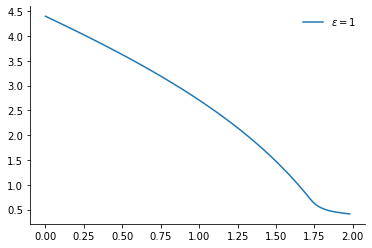

In [35]:
plt.plot(y_grid_short, model_res['v0'], label=r'$\epsilon=1.$')
plt.legend(frameon=False)

In [36]:
et, yt, ht, gt = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1., T=100)

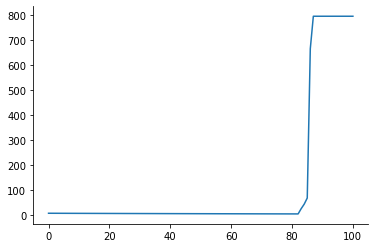

In [37]:
plt.plot(et)